In [1]:
!pip install wordcloud

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from collections import Counter, defaultdict
from bs4 import BeautifulSoup
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\felip\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Load Data

Data [IMDB 50K Movie Review](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews)

In [3]:
import requests

url = "https://raw.githubusercontent.com/cockles98/MachineLearning_from_Scratch/master/data/imdb/IMDB_Dataset.csv"
response = requests.get(url)

with open("imdb_dataset.csv", "wb") as file:
    file.write(response.content)
    
df = pd.read_csv("imdb_dataset.csv")

In [4]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


# Data Exploration

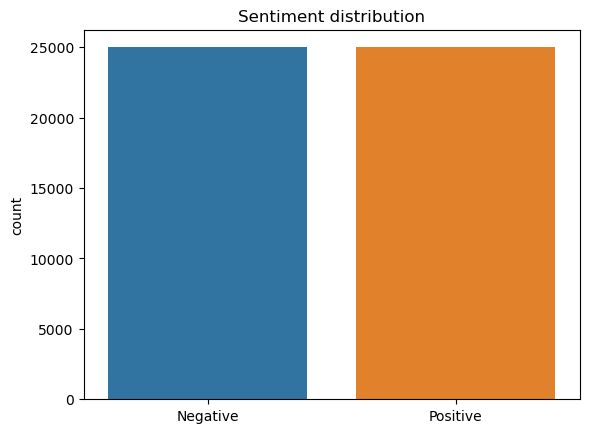

In [5]:
f = sns.countplot(x='sentiment', data=df)
f.set_title("Sentiment distribution")
f.set_xticklabels(['Negative', 'Positive'])
plt.xlabel("");

Most common words

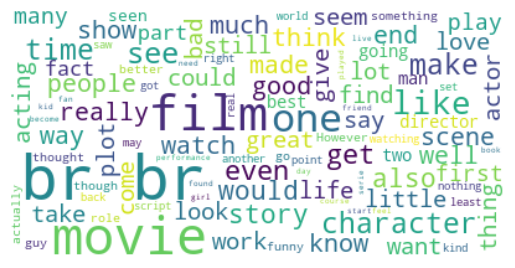

In [6]:
text = " ".join(review for review in df.review)

wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", stopwords=stopwords.words("english")).generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show();

# Sentiment Analysis

In [7]:
class Tokenizer:
  
    def clean(self, text):
        no_html = BeautifulSoup(text).get_text()
        clean = re.sub("[^a-z\s]+", " ", no_html, flags=re.IGNORECASE)
        return re.sub("(\s+)", " ", clean)

 
    def tokenize(self, text):
        clean = self.clean(text).lower()
        stopwords_en = stopwords.words("english")
        return [w for w in re.split("\W+", clean) if not w in stopwords_en]

In [8]:
class MultinomialNaiveBayes:
  
    def __init__(self, classes, tokenizer):
        self.tokenizer = tokenizer
        self.classes = classes
      
    def group_by_class(self, X, y):
        data = dict()
        for c in self.classes:
            data[c] = X[np.where(y == c)]
        return data
           
    def fit(self, X, y):
        self.n_class_items = {}
        self.log_class_priors = {}
        self.word_counts = {}
        self.vocab = set()

        n = len(X)
        
        grouped_data = self.group_by_class(X, y)
        
        for c, data in grouped_data.items():
            self.n_class_items[c] = len(data)
            self.log_class_priors[c] = math.log(self.n_class_items[c] / n)
            self.word_counts[c] = defaultdict(lambda: 0)
          
            for text in data:
                counts = Counter(self.tokenizer.tokenize(text))
                for word, count in counts.items():
                    if word not in self.vocab:
                        self.vocab.add(word)

                    self.word_counts[c][word] += count
                
        return self
      
    def laplace_smoothing(self, word, text_class):
        num = self.word_counts[text_class][word] + 1
        denom = self.n_class_items[text_class] + len(self.vocab)
        return math.log(num / denom)
      
    def predict(self, X):
        result = []
        for text in X:
          
            class_scores = {c: self.log_class_priors[c] for c in self.classes}

            words = set(self.tokenizer.tokenize(text))
            for word in words:
                if word not in self.vocab: continue

                for c in self.classes:
                
                    log_w_given_c = self.laplace_smoothing(word, c)
                    class_scores[c] += log_w_given_c
                
            result.append(max(class_scores, key=class_scores.get))

        return result

In [9]:
X = df['review'].values
y = df['sentiment'].values
  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [10]:
MNB = MultinomialNaiveBayes(classes=np.unique(y), tokenizer=Tokenizer()).fit(X_train, y_train)

C:\Users\felip\AppData\Local\Temp\ipykernel_11272\2827012130.py:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  no_html = BeautifulSoup(text).get_text()


In [11]:
y_hat = MNB.predict(X_test)

C:\Users\felip\AppData\Local\Temp\ipykernel_11272\2827012130.py:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  no_html = BeautifulSoup(text).get_text()


# Evaluation

In [12]:
accuracy_score(y_test, y_hat)

0.8594

In [13]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

    negative       0.88      0.83      0.85      4961
    positive       0.84      0.89      0.86      5039

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [14]:
cnf_matrix = confusion_matrix(y_test, y_hat)
cnf_matrix

array([[4125,  836],
       [ 570, 4469]], dtype=int64)

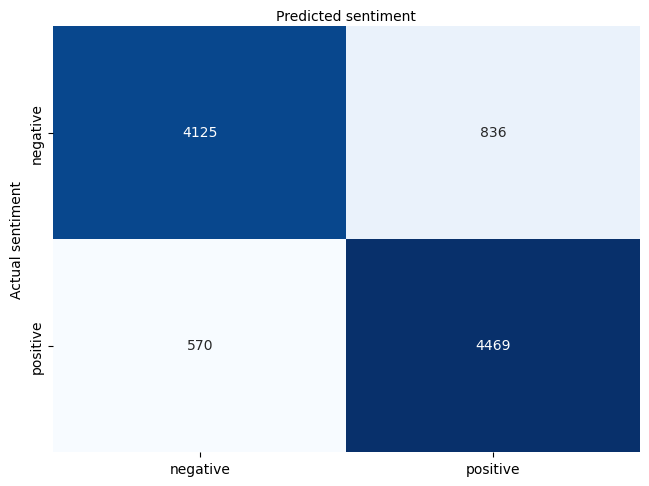

In [15]:
class_names = ["negative", "positive"]
fig,ax = plt.subplots()


sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="Blues", fmt="d", cbar=False, xticklabels=class_names, yticklabels=class_names)
ax.xaxis.set_label_position('top')
plt.tight_layout()
plt.ylabel('Actual sentiment')
plt.xlabel('Predicted sentiment');